## Тестовый блокнот, использование GPU

In [1]:
import datetime
import os

import numpy as np  
import tensorflow as tf

from keras.layers import Input, Dense, Flatten, Reshape  
from keras.models import Model  
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D  

import matplotlib
import matplotlib.pyplot as plt

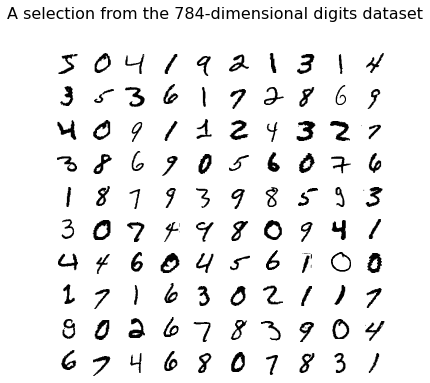

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train.shape, y_train.shape, x_test.shape, y_test.shape

# Подготовка к TF(Keras)
# нормализуем и получаем данные от 0 до 1
x_train = x_train.astype('float32') / 255.  
x_test  = x_test.astype('float32') / 255.
# Решэйпим  
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1))  

fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(6, 6))
for idx, ax in enumerate(axs.ravel()):
    ax.imshow(x_train[idx].reshape((28, 28)), cmap=plt.cm.binary)
    ax.axis("off")
_ = fig.suptitle("A selection from the 784-dimensional digits dataset", fontsize=16)

In [3]:
def plot_digits(*args):  
    args = [x.squeeze() for x in args]  
    n = min([x.shape[0] for x in args])  
    plt.figure(figsize=(2*n, 2*len(args)))  
    for j in range(n):  
        for i in range(len(args)):  
            ax = plt.subplot(len(args), n, i*n + j + 1)
            ax.imshow(args[i][j], cmap=plt.cm.binary)
            ax.axis("off")  
    plt.show() 

In [4]:
def create_deep_conv_ae():  
    input_img = Input(shape=(28, 28, 1))  
  
    x = Conv2D(128, (7, 7), activation='relu', padding='same')(input_img)  
    x = MaxPooling2D((2, 2), padding='same')(x)  
    x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)  
    x = MaxPooling2D((2, 2), padding='same')(x)  
    encoded = Conv2D(1, (7, 7), activation='relu', padding='same')(x)  
  
    # На этом моменте представление  (7, 7, 1) т.е. 25-размерное  
  
    input_encoded = Input(shape=(7, 7, 1))  
    x = Conv2D(32, (7, 7), activation='relu', padding='same')(input_encoded)  
    x = UpSampling2D((2, 2))(x)  
    x = Conv2D(128, (2, 2), activation='relu', padding='same')(x)  
    x = UpSampling2D((2, 2))(x)  
    decoded = Conv2D(1, (7, 7), activation='sigmoid', padding='same')(x)  
  
    # Модели  
    encoder = Model(input_img, encoded, name="encoder")  
    decoder = Model(input_encoded, decoded, name="decoder")  
    autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")  
    return encoder, decoder, autoencoder  
  

# GPU
c_encoder, c_decoder, c_autoencoder = create_deep_conv_ae()  
c_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')  

c_autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 7, 7, 1)           24385     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         24385     
                                                                 
Total params: 48,770
Trainable params: 48,770
Non-trainable params: 0
_________________________________________________________________


In [9]:
## %%time

c_autoencoder.fit(x_train, x_train,  
                epochs=5,  
                batch_size=256,  
                shuffle=True,  
                validation_data=(x_test, x_test)
                )

Epoch 1/5
235/235 [==============================] - 24s 103ms/step - loss: 0.0779 - val_loss: 0.0762
Epoch 2/5
235/235 [==============================] - 24s 103ms/step - loss: 0.0772 - val_loss: 0.0756
Epoch 3/5
235/235 [==============================] - 24s 103ms/step - loss: 0.0764 - val_loss: 0.0751
Epoch 4/5
235/235 [==============================] - 24s 103ms/step - loss: 0.0760 - val_loss: 0.0750
Epoch 5/5
235/235 [==============================] - 24s 103ms/step - loss: 0.0754 - val_loss: 0.0743


1/1 [==============================] - 0s 18ms/step


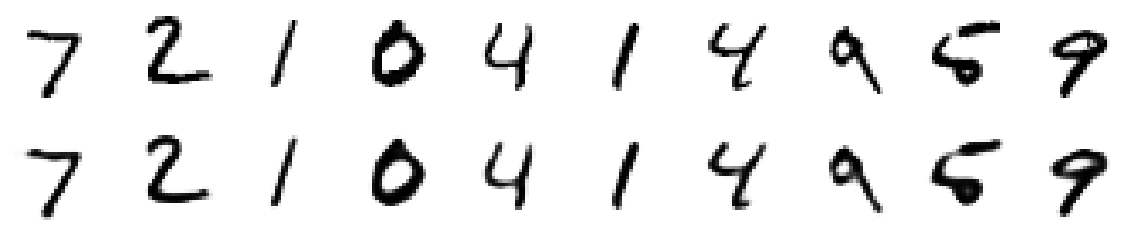

In [10]:
n = 10  

imgs = x_test[:n]  
encoded_imgs = c_encoder.predict(imgs, batch_size=n)  
decoded_imgs = c_decoder.predict(encoded_imgs, batch_size=n)  
  
plot_digits(imgs, decoded_imgs)  